<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw12/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 101 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=8dd491b1f36f51d1040ac2edbd14ed888d140e324cf8f0b846808b356bd45701
  Stored in directory: /tmp/pip-ephem-wheel-cache-wm12ree0/wheels/55/59/29/0fb1c635652

In [1]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [24]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import trange, tqdm

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_bn_eval(m):
    if isinstance(m, nn.modules.batchnorm._BatchNorm):
        m.eval()

def set_bn_train(m):
    if isinstance(m, nn.modules.batchnorm._BatchNorm):
        m.train()


class ConvSmallVAT(nn.Module):
    # taken from appendix, literally
    def __init__(self, input_channels, dropout=0.5):
      super().__init__()
      self.block1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout),
      )
      self.block2 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout)
      )
      self.block3 = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(192)
      )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)

        return out.flatten(1)

class VAT(nn.Module):
    def __init__(self, input_channels=3, num_classes=10, dropout=0.5, xi=10.0, alpha=1.0):
        super().__init__()

        self.xi = xi
        self.alpha = alpha
        self.encoder = ConvSmallVAT(input_channels, dropout)
        self.classifier = nn.Linear(192, num_classes)

    def __loss_l(self, x, classes):
        return F.cross_entropy(self.forward(x), classes)

    def __loss_ul(self, x):
        # какая же духота
        # inspiration: https://github.com/takerum/vat_chainer/blob/7b6fa23afa3a2a49facbc7aac96476b5225fedfb/source/chainer_functions/loss.py#L66
        with torch.no_grad():
            probs = F.softmax(self.forward(x), dim=1)

        d = F.normalize(torch.randn_like(x, device=device), p=2, dim=(1, 2, 3))

        # TODO: how to disable batch norm stats?
        # self.encoder.apply(set_bn_eval)

        r = (d * self.xi).requires_grad_(True)

        log_probs_adv = F.log_softmax(self.forward(x + r), dim=1)
        dist_adv = F.kl_div(log_probs_adv, probs, reduction="batchmean")
        
        dist_adv.backward()
        r_adv = F.normalize(r.grad, p=2, dim=(1, 2, 3))
        self.encoder.zero_grad()
        self.classifier.zero_grad()

        log_probs_adv = F.log_softmax(self.forward(x + r_adv), dim=1)
        loss_ul = F.kl_div(log_probs_adv, probs, reduction="batchmean")

        # self.encoder.apply(set_bn_train)

        return loss_ul

    def __loss(self, batch):
        x, y = batch
        labeled = (y != -1)
        loss = self.__loss_l(x[labeled], y[labeled]) + self.alpha * self.__loss_ul(x)

        return loss

    def forward(self, x):
        return self.classifier(self.encoder(x))

    @torch.no_grad()
    def test(self, test_dataloader): 
        self.eval()
        total = correct = 0
         
        for (x, y) in test_dataloader: 
            x, y = x.float().to(device), y.to(device)
            pred = self.forward(x)
            correct += (torch.argmax(pred, dim=1) == y).sum().item()
            total += len(x)
        self.train()
        return correct / total

    def fit(self, train_dataloader, test_dataloader, epochs=10, lr=1e-4):
        optim = Adam(self.parameters(), lr=lr)

        losses, accuracy = [], [self.test(test_dataloader)]
        
        for _ in trange(epochs, desc="Training"):
            for batch in tqdm(train_dataloader, desc="Epoch"):
                batch = [b.to(device) for b in batch]

                loss = self.__loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.detach().cpu().numpy())

            accuracy.append(self.test(test_dataloader))

        return np.array(losses), np.array(accuracy)

In [25]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
    test_dataloader = DataLoader(test_data, batch_size=128)
    
    model = VAT(xi=1).to(device)
    losses, accs = model.fit(train_dataloader, test_dataloader, epochs=4, lr=1e-4)
    
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch:   0%|          | 0/390 [00:00<?, ?it/s]

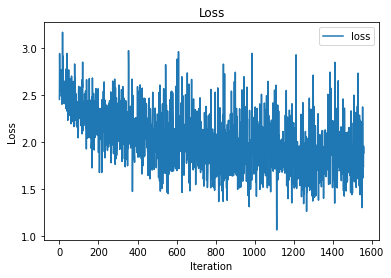

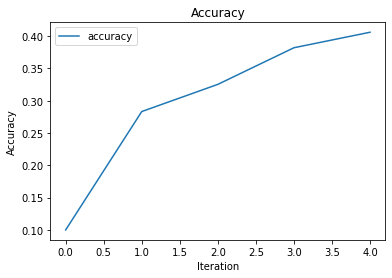

In [26]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """